# Get Data 

In [34]:
import pandas as pd
import math 
import os
import numpy as np

data_type = 'word'
sample = 'all'


if data_type == 'num':
    labels_count = 2
else:
    labels_count = 10 

def generate_data(data_type, testing_subjects):
    '''
    returns a training test split based on files read from directory 
    :param data_type: pass either 'word' or 'num'
    :param training_subjects: number of training subjects 2 or greater
    :return: returns a traning and test dataframe 
    '''
    testing = []
    data_final = []
    main_dir = os.listdir('data/subjects/') 
    steps = 1
    for direc in main_dir: 
        if data_type in direc:
            main_file = os.listdir('data/subjects/'+ direc)
            for file in main_file:
                if 'final' in file:
                    data = pd.read_csv('data/subjects/'+ direc+'/'+file)
                    data_final.append(data)
                    
    data = pd.concat(data_final, ignore_index = True)
    data.dropna(inplace=True)
    data.reset_index(inplace = True, drop = True)
    return data


if sample != 'all':
    training = pd.read_csv('data/subjects/'+ sample +'/'+sample+'_final.csv')
else:
    training = generate_data(data_type, 2)

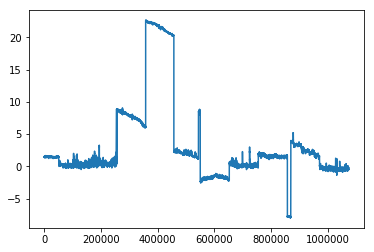

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Right Jaw 
plt.plot('CH_1_mV', data = training)
plt.show()

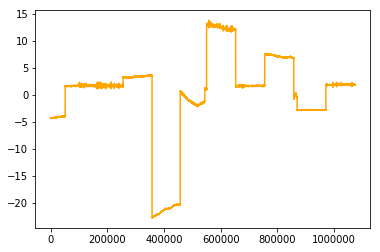

In [36]:
# Left Cheeck
plt.plot('CH_2_mV', data= training,  color='orange')
plt.show()

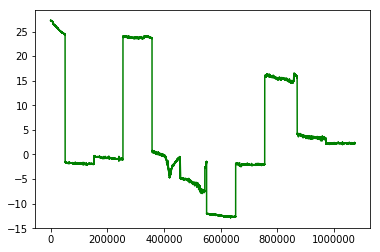

In [37]:
# Throat
plt.plot('CH_3_mV', data= training,  color='green')
plt.show()

# Clean Data 

In [38]:
# add Low pass filter 

def low_pass(fc, b):
    '''
    :param fc: cutoff frequency
    :param b: bandwidth
    :return: low pass filter
    '''
    N = int(np.ceil((4 / b)))
    if not N % 2: N += 1
    n = np.arange(N)
    sinc_func = np.sinc(2 * fc * (n - (N - 1) / 2.))
    window = np.blackman(N)
    sinc_func = sinc_func * window
    sinc_func = sinc_func / np.sum(sinc_func)
    return sinc_func

# look up time-domain vs frequency domain relationship 

In [39]:
# add high pass filter

def high_pass(fc, b):
    '''
    :param fc: cutoff frequency
    :param b: bandwidth
    :return: high pass filter
    '''
    N = int(np.ceil((4 / b)))
    if not N % 2: N += 1
    n = np.arange(N)

    sinc_func = np.sinc(2 * fc * (n - (N - 1) / 2.))
    window = np.blackman(N)
    sinc_func = sinc_func * window
    sinc_func = sinc_func / np.sum(sinc_func)

    # reverse function
    sinc_func = -sinc_func
    sinc_func[int((N - 1) / 2)] += 1
    return sinc_func

# look up time-domain vs frequency domain relationship 

In [40]:
# Create new dataframe after filtering data 

def low_pass_data(fc,bw, data):
    lp_filter = low_pass(fc,bw)
    cln= {'CH_1_mV': np.convolve(data['CH_1_mV'], lp_filter), 
          'CH_2_mV': np.convolve(data['CH_2_mV'], lp_filter),
          'CH_3_mV': np.convolve(data['CH_3_mV'], lp_filter)}
    output = pd.DataFrame(cln)
    diff = len(output)- len(data)
    del_rows = diff/2
    output = output.loc[del_rows:len(output)-del_rows-1]
    output.dropna(inplace=True)
    output.reset_index(inplace = True, drop = True)
    output['Target'] = data['Target']
    return output 


def high_pass_data(fc,bw, data):
    hp_filter = high_pass(fc,bw)
    cln= {'CH_1_mV': np.convolve(data['CH_1_mV'],hp_filter), 
          'CH_2_mV': np.convolve(data['CH_2_mV'],hp_filter),
          'CH_3_mV': np.convolve(data['CH_3_mV'],hp_filter)}
    output = pd.DataFrame(cln)
    diff = len(output)- len(data)
    del_rows = diff/2
    output = output.loc[del_rows:len(output)-del_rows-1]
    output.dropna(inplace=True)
    output.reset_index(inplace = True, drop = True)
    output['Target'] = data['Target']
    return output 

def round_up_to_even(f):
    return math.ceil(f / 2.) * 2


low_pass_training = low_pass_data(0.04,0.08,training)
filtered_training = high_pass_data(0.001,0.002, low_pass_training)

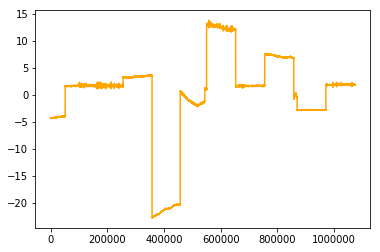

In [41]:
# Left Cheeck
plt.plot('CH_2_mV', data= training, color='orange')
plt.show()

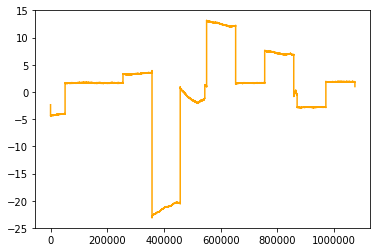

In [42]:
# Left Cheeck
plt.plot('CH_2_mV', data = low_pass_training,  color='orange')
plt.show()

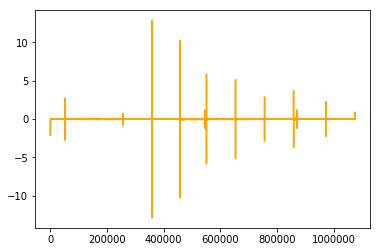

In [43]:
# Left Cheeck
plt.plot('CH_2_mV', data = filtered_training,  color='orange')
plt.show()

In [44]:
filtered_training['Target'].unique()

array(['relax', 'no', 'yes'], dtype=object)

In [45]:
# deterime value ranges for targets 
import more_itertools as mit

def min_max(data, val ='targets'):
    targets = []
    if val == 'targets':
         values = data[data['Target'] != 'relax'].index.tolist()
    else:
         values = data[data['Target'] == 'relax'].index.tolist()
    groups = [list(group) for group in mit.consecutive_groups(values)]
    targets = [lst[0] for lst in groups]
    return groups, targets 

groups, targets = min_max(filtered_training,'targets')
groups_non, targets_non = min_max(filtered_training,val = 'non')

# Visualize filtered data

In [46]:
 def create_plots(rows, data, item = 'all'):
    '''
    :param rows: rows from ranges of taget values 
    :param data: data frame to use
    :return: plot of signals
    '''
    if item == data.iloc[min(rows) + 10]['Target'] or item == 'all':
        
        plt.figure(figsize=(25,5))

        plt.subplot(1,4,1)
        plt.plot(data['CH_1_mV'][min(rows):max(rows)])

        plt.subplot(1,4,2)
        plt.plot(data['CH_2_mV'][min(rows):max(rows)])

        plt.subplot(1,4,3)
        plt.plot(data['CH_3_mV'][min(rows):max(rows)])

        plt.subplot(1,4,4)
        plt.text(0.35, 0.5, data.iloc[min(rows) + 10]['Target'] , dict(size=25))

        plt.show()

In [47]:
# # Plot Results 
# for rows in groups:
#     create_plots(rows, filtered_training)

In [48]:
# Find average length of each signal

def max_len(groups):
    avg_len = [(max(val)-min(val)) for val in groups]
    avg = sum(avg_len)/len(avg_len)
    return avg

In [49]:
filtered_training.head()

,CH_1_mV,CH_2_mV,CH_3_mV,Target
0,0.076485,-0.186896,1.188067,relax
1,0.192417,-0.528753,3.323464,relax
2,0.301876,-0.853243,5.349169,relax
3,0.401430,-1.150257,7.202120,relax
4,0.488444,-1.411888,8.833124,relax


# Transform Data 

In [50]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler

val = 'z'

filtered_training = filtered_training.copy()
col_names = list(filtered_training.columns[:-1])
features = filtered_training[col_names]
if val == 'z':
    scaler = StandardScaler().fit(features.values)
    features = scaler.transform(features.values)
    filtered_training[col_names] = features
else:
    scaler = MinMaxScaler().fit(features.values)
    features = scaler.transform(features.values)
    filtered_training[col_names] = features

In [51]:
# # Transform data with normaizliation 
# def trans_data_train(df, val = 'z'):
#     for col in df:
#         if col not in ['Target']:
#             if val == 'z':  
#                 #take the z-score 
#                 df[col] = (df[col] - df[col].mean())/df[col].std(ddof=0)
#             else:
#                 #normaizize data between [0,1]
#                 df[col]=(df[col]-df[col].min())/(df[col].max()-df[col].min())
         
        
# def trans_data_test(df_test, df_train, val ='z'):
#     for col in df_test:
#         if col not in ['Target']:
#             if val == 'z':
#                 #take the z-score 
#                 df_test[col] = (df_test[col] - df_train[col].mean())/df_train[col].std(ddof=0)
#             else:
#                 #normaizize data between [0,1]
#                 df_test[col]=(df_test[col]-df_test[col].min())/(df_test[col].max()-df_test[col].min())                                  
                
# trans_data_train(filtered_training,'z')

In [52]:
# Transform Target column to intergers 

def new_cat_word(row):
    if row == 'relax':
        return 99
    if row == 'no':
        return 0
    else:
        return 1
    
def new_cat_num(row):
    if row == 'relax':
        return 99
    if row == '1':
        return 1
    if row == '2':
        return 2
    if row == '3':
        return 3
    if row == '4':
        return 4
    if row == '5':
        return 5
    if row == '6':
        return 6
    if row == '7':
        return 7
    if row == '8':
        return 8
    if row == '9':
        return 9
    if row == '0':
        return 0

def target_col(val='num'):
    if val == 'num':
        filtered_training['Target'] = filtered_training['Target'].apply(new_cat_num)
    else:
        filtered_training['Target'] = filtered_training['Target'].apply(new_cat_word)

        
target_col(data_type)

In [53]:
filtered_training.head()

,CH_1_mV,CH_2_mV,CH_3_mV,Target
0,0.353974,-0.754065,3.488810,99
1,0.890947,-2.134538,9.769388,99
2,1.397939,-3.444879,15.727340,99
3,1.859051,-4.644268,21.177194,99
4,2.262082,-5.700772,25.974265,99


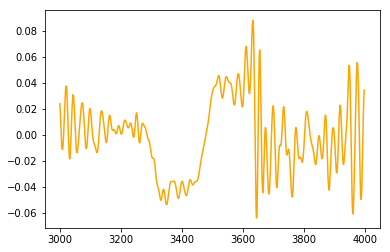

In [54]:
# Left Cheeck
plt.plot('CH_2_mV', data = filtered_training[3000:4000],  color='orange')
plt.show()

In [55]:
# split the data 
from sklearn.model_selection import train_test_split

X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(groups,targets, 
                                                    test_size=0.10, random_state=42)

In [56]:
X_train = [filtered_training[['CH_1_mV', 'CH_2_mV', 'CH_3_mV']].loc[min(val):max(val)].values for val in X_train_val]
y_train = [filtered_training['Target'][val] for val in y_train_val]
X_test = [filtered_training[['CH_1_mV', 'CH_2_mV','CH_3_mV']].loc[min(val):max(val)].values for val in X_test_val]
y_test = [filtered_training['Target'][val] for val in y_test_val]

# Shape Data

In [57]:
from keras.preprocessing import sequence
import tensorflow as tf

max_length = round_up_to_even(max_len(groups))

X_train = sequence.pad_sequences(X_train, dtype ='float32', maxlen = max_length, padding = 'post', truncating = 'post')
y_train = np.array(y_train)
X_test = sequence.pad_sequences(X_test, dtype ='float32', maxlen = max_length, padding = 'post', truncating = 'post')
y_test = np.array(y_test)

In [58]:
X_train.shape

(474, 1020, 3)

In [59]:
y_train.shape

(474,)

In [60]:
X_test.shape

(53, 1020, 3)

In [61]:
y_test.shape

(53,)

# Save Data 

In [62]:
np.save('data/X_train', X_train)
np.save('data/X_test', X_test)
np.save('data/y_train', y_train)
np.save('data/y_test', y_test)
np.save('data/max', max_length)